In [318]:
#
# Color space
#
# Here xyz and rgb means
# - xyz (CIE 1931 xyz)
# - rgb (Rec. 709 rgb)
#
# Data is from http://www.cvrl.org
#   - CIE 1931 XYZ color matching function
#     curl -X POST http://cvrl.ioo.ucl.ac.uk/offercsvcmfs.php -d whichfile=ciexyz31.csv
#   - CIE Standard Illuminant D65
#     curl -X POST http://cvrl.ioo.ucl.ac.uk/offercsvillum.php -d whichfile=Illuminantd65.csv
#

# TODO (essentially, reproduce all the plotting about CIE)
# - [x] plot D65
# - [x] plot xyz color matching function (aka kernel)
# - [x] plot Planck's law (at T = 6500K)
# - [x] resample xyz kernel
# - [x] spectrum to XYZ by integration
# - [x] xy chromaticity diagram
#   - [x] spectral locus
#   - [x] D65
#   - [x] Planckian locus
#   - [x] Rec709 gamut triangle
#     - [x] primary rgb
#     - [x] draw color by "XYZ to Rec709 RGB"
# - [-] follow example ordinary value of power/irradiance/radiance/xyz/rgb
#   - [x] blender's lighting model
#     - Rec701 RGB
#     - [x] compare simple scene with pbrt
#       - point light 1m above diffuse white plane
#         (NOTE: pbrt's point light has I [J/s . 1/sr])
#     - light watt (J/s)
#     - sun strength (J/s . 1/m^2)
#   - [x] pbrt's lighting model
#     - input, internal: Spectrum
#     - film pixel: CIE XYZ
#     - output: linear rgb (Rec701, sRGB)
#   - example value of color temperature
#   - example value of luminous efficacy
#   - typical examples
#     - incandescent light
#       - efficacy 0.05
#       - color temperature 3000K
#       - 100W power
#     - fluorescent light
#       - efficacy 0.2
#     - [ ] sun/sky light
#   - [-] display
#     - LED backlight
#     - LCD filter
# - [x] planck's law and color temperature
#   - project planckian radiation to Rec701 RGB
# - [-] visualize XYZ in 3D
#   - [ ] Rec709 RGB gamut cube
#   - [ ] spectral locus
#   - [ ] original RGB
# - [x] original CIE RGB primary experiment plot
# - [-] "canonicity" of construction
#   - [x] convexity linear color space gamut of xy chromaticity diagram
#     - since xy diagram is perspective projection of XYZ (with "lookat" (1, 1, 1)), straight line is preserved.
#   - (https://doi.org/10.1002%2F%28SICI%291520-6378%28199702%2922%3A1%3C11%3A%3AAID-COL4%3E3.0.CO%3B2-7)
#

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipyw
import requests, csv

In [4]:
#
# Download data
#

xyz_csv = requests.post('http://cvrl.ioo.ucl.ac.uk/offercsvcmfs.php', data=dict(whichfile='ciexyz31.csv')).text
d65_csv = requests.post('http://cvrl.ioo.ucl.ac.uk/offercsvillum.php', data=dict(whichfile='Illuminantd65.csv')).text

# range 360nm - 830nm
# sample 5nm (but [1/nm] density)
xyz_kernel = np.array([l.split(',') for l in xyz_csv.splitlines()], dtype=np.float)

# range 300nm - 830nm
# sample 1nm
d65_spectrum = np.array([l.split(', ') for l in d65_csv.splitlines()], dtype=np.float)

xyz_kernel[:2], \
xyz_kernel[-2:], \
d65_spectrum[:2], \
d65_spectrum[-2:], \

(array([[3.600e+02, 1.299e-04, 3.917e-06, 6.061e-04],
        [3.650e+02, 2.321e-04, 6.965e-06, 1.086e-03]]),
 array([[8.250000e+02, 1.776509e-06, 6.415300e-07, 0.000000e+00],
        [8.300000e+02, 1.251141e-06, 4.518100e-07, 0.000000e+00]]),
 array([[3.0000e+02, 3.4100e-02],
        [3.0100e+02, 3.6014e-01]]),
 array([[829.    ,  60.0253],
        [830.    ,  60.3125]]))

In [62]:
#
# Linear interporate kernel from original 5nm step to 1nm step
# (TODO: piecewise Hermite cubic (derivative from finite difference))
#

def linear_interp_xyz_kernel(xyz_kernel): # xyz_kernel: float(?, 4)
    # Resample from 360, 365, .., 825, 830
    #          to   361, 362, .., 829, 830
    l, x, y, z = xyz_kernel[:, :].T
    l0 = np.int(l[0])
    l1 = np.int(l[-1])
    assert all(l[1:] - l[:-1] == 5)
    assert l0  == 360
    assert l1 == 830
    
    l_r = np.arange(l0, l1 + 1).astype(np.float)
    x_r = np.interp(l_r, l, x)
    y_r = np.interp(l_r, l, y)
    z_r = np.interp(l_r, l, z)
    return np.stack([l_r, x_r, y_r, z_r], axis=-1)


xyz_kernel_resampled = linear_interp_xyz_kernel(xyz_kernel)
xyz_kernel_resampled[:3]

array([[3.6000e+02, 1.2990e-04, 3.9170e-06, 6.0610e-04],
       [3.6100e+02, 1.5034e-04, 4.5266e-06, 7.0208e-04],
       [3.6200e+02, 1.7078e-04, 5.1362e-06, 7.9806e-04]])

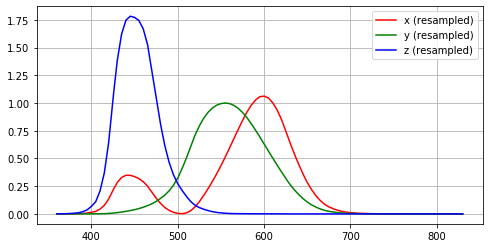

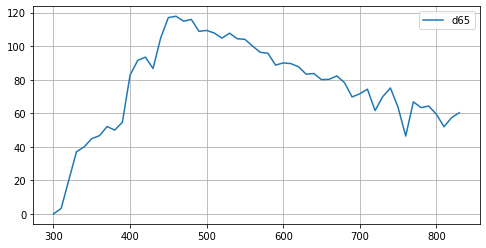

In [81]:
#
# Plot data (xyz kernels, standard illuminant D65)
#
def _1():
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.grid()
    ax.plot(*xyz_kernel_resampled[:, [0, 1]].T, label='x (resampled)', color='r')
    ax.plot(*xyz_kernel_resampled[:, [0, 2]].T, label='y (resampled)', color='g')
    ax.plot(*xyz_kernel_resampled[:, [0, 3]].T, label='z (resampled)', color='b')
    ax.legend()
    
def _2():
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.grid()
    ax.plot(*d65_spectrum.T, label='d65')
    ax.legend()
    
_1()    
_2()

In [150]:
#
# spectrum to XYZ by integration
#

def integrate_xyz(spectrum): # spectrum: float(?, 2)  ->  XYZ
    l_spec, v = spectrum[(360 <= spectrum.T[0]) * (spectrum.T[0] <= 830)].T
    l, x, y, z = xyz_kernel_resampled.T
    assert all(l_spec == l)
    X = np.sum(v * x)
    Y = np.sum(v * y)
    Z = np.sum(v * z)
    return X, Y, Z

# this transform can be seen as perspective transform looking at (1, 1, 1)
def XYZ_to_xyz(XYZ):
    return [_ / sum(XYZ) for _ in XYZ]
    
def XYZ_to_xyY(XYZ):
    x, y, _ = XYZ_to_xyz(XYZ)
    return x, y, XYZ[1]

def xyY_to_XYZ(xyY):
    x, y, Y = xyY
    X = (Y / y) * x
    Z = (Y / y) * (1 - x - y)
    return X, Y, Z

integrate_xyz(d65_spectrum), \
XYZ_to_xyY(integrate_xyz(d65_spectrum))

((10043.51981205919, 10566.885734213669, 11503.937596979094),
 (0.31274249537841137, 0.32903944779683414, 10566.885734213669))

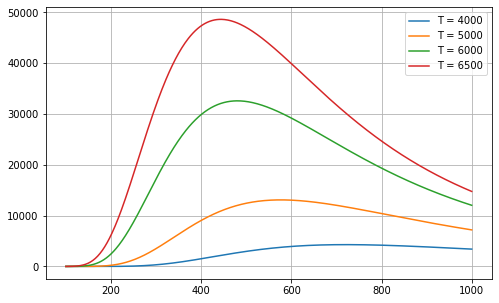

In [94]:
#
# Planck's law
# (radiance from photon gas equilibrium at temperature T)
# (radiance as density wrt wave length (nm))
#
def planck_law_ufunc(T, lam):
    # 
    # Angular frequency density of Energy density 
    #   u(ome) = 1 / (pi^2 c^3) * h_bar ome^3 / (exp(h_bar ome / k T) - 1)
    #
    # Homogeneous/isotropic radiance implies
    #   L = u * c / 4pi
    #
    # By change of measure via `ome = 2pi c / lam`
    #   L(lam)  = 2 h c^2 / (lam^5 * (exp((h c) / (k T lam)) - 1))
    #
    # Also, change of measure via lam = 10^-9 lam_nm
    #
    
    # Constants
    c = 3.0 * 1e8
    h = 6.6 * 1e-34
    k = 8.3 / (6.0 * 1e23) # R / Na
    
    # lam: [m]
    # L:   [J/s . 1/srad . 1/m^2 . 1/m]
    L = 2 * h * c**2 / (lam**5 * (np.exp((h * c) / (k * T * lam)) - 1))    
    return L

    
def _():
    Ts = [4000, 5000, 6000, 6500]
    lam0_nm = 100
    lam1_nm = 1000

    # lam_nm : [nm]
    # L_nm   : [J/s . 1/srad  . 1/m^2 . 1/nm]
    lam_nm = np.linspace(lam0_nm, lam1_nm, num=2**9)
    Ls_nm = [planck_law_ufunc(T, lam_nm * 1e-9) * 1e-9 for T in Ts]
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    for T, L_nm in zip(Ts, Ls_nm):
        ax.plot(lam_nm, L_nm, label=f"T = {T}")
    ax.legend()    
    ax.grid()
    
_()

In [179]:
#
# RGB color space transformation (Rec.709, sRGB)
#
# Cf.
# - Rec.709 (https://www.itu.int/dms_pubrec/itu-r/rec/bt/R-REC-BT.709-6-201506-I!!PDF-E.pdf)
# - sRGB (obsolete but open document https://www.w3.org/Graphics/Color/sRGB)
#

# From Rec.709 spec
# 1. xy chromaticity of primaries
xy_r = [0.640, 0.330]
xy_g = [0.300, 0.600]
xy_b = [0.150, 0.060]
# 2. luminance value (gamma-corrected?)
Ygamma_rgb = [0.2126, 0.7152, 0.0722] 
Y_r, Y_g, Y_b = [_ ** 1 for _ in Ygamma_rgb] # Rec.709 spec seems saying it should be (_ ** 2.2)

# From that data, we have unique invertible linear map rgb <-> XYZ
rgb_to_XYZ = np.array([
    xyY_to_XYZ([*xy_r, Y_r]),
    xyY_to_XYZ([*xy_g, Y_g]),
    xyY_to_XYZ([*xy_b, Y_b])
]).T

rgb_to_XYZ, \
np.linalg.inv(rgb_to_XYZ)

(array([[0.41231515, 0.3576    , 0.1805    ],
        [0.2126    , 0.7152    , 0.0722    ],
        [0.01932727, 0.1192    , 0.95063333]]),
 array([[ 3.24156456, -1.53766524, -0.49870224],
        [-0.96920119,  1.87588535,  0.04155324],
        [ 0.05562416, -0.20395525,  1.05685902]]))

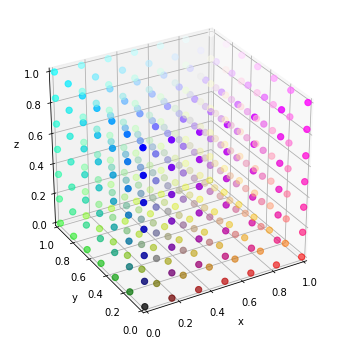

In [370]:
#
# Color cube grid
#

import mpl_toolkits.mplot3d

def _(num, elev, azim):
    t = np.linspace(0, 1, num=num)
    xx, yy, zz = [_.reshape(-1) for _ in np.meshgrid(t, t, t)]
    c = np.stack([xx, yy, zz], axis=-1) ** (1/2.2)
    
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='3d'))
    ax.scatter(xx, yy, zz, s=40, c=c)
    ax.view_init(elev, azim)
    ax.set(xlim=[0, 1], ylim=[0, 1], zlim=[0, 1], xlabel='x', ylabel='y', zlabel='z')

_(num=7, elev=30, azim=-120)
# ipyw.interact(num=ipyw.IntText(7), elev=ipyw.IntText(30, step=10), azim=ipyw.IntText(-120, step=10))(_)    

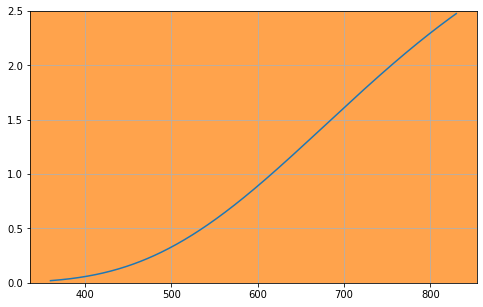

In [347]:
#
# Rec701 RGB from Planck's law (aka color temperature)
#

def _(T):
    lam_nm = xyz_kernel_resampled[:, 0]
    spectrum = planck_law_ufunc(T, lam_nm * 1e-9) * 1e-9
    XYZ = integrate_xyz(np.stack([lam_nm, spectrum], axis=-1))
    Y = XYZ[1]
    rgb = np.linalg.inv(rgb_to_XYZ) @ XYZ
    
    # Make maximum component is 1
    rgb_norm = rgb / max(*rgb)
    rgb_norm ** (1/2.2)

    # Make average height is 1
    spectrum_norm = spectrum / (sum(spectrum) / len(lam_nm))
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(lam_nm, spectrum_norm)
    ax.set_facecolor(rgb_norm ** (1/2.2))
    ax.set(ylim=[0, 2.5])
    ax.grid()    

_(T=2500)
# ipyw.interact(T=ipyw.IntText(2500, step=500))(_)

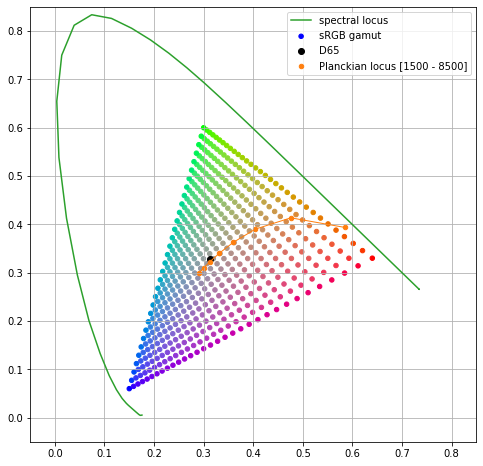

In [316]:
#
# xy(Y) chromaticity diagram
#
# NOTE: 
# - xyz_kernel produces XYZ coordinates
# - xyz is XYZ coordinates scaled to X + Y + Z = 1 plane (aka normalization)
# - xyz_kernel's each bin can be considered to be its integral with monochromatic ray of bin width 
#


def fill_rgb_triangle(num=2**4): # -> float(?, 3)
    t = np.linspace(0, 1, num)
    u, v = [_.reshape(-1) for _ in np.meshgrid(t, t)] # u, v: float(?)
    mask = u + v <= 1
    u = u[mask].reshape((-1, 1)) # u, v: float(?, 1)
    v = v[mask].reshape((-1, 1))

    r, g, b = np.eye(3) # r, g, b: float(3)
    rgb = b + u * (r - b) + v * (g - b) # rgb: float(?, 3)
    return np.clip(rgb, 0, 1)


def _():
    # 1. spectral locus 
    X, Y, Z = xyz_kernel_resampled[:, 1:].T
    x = X / (X + Y + Z)
    y = Y / (X + Y + Z)
    
    # 2. D65
    XYZ_d65 = integrate_xyz(d65_spectrum)
    x_d65 = XYZ_d65[0] / sum(XYZ_d65)
    y_d65 = XYZ_d65[1] / sum(XYZ_d65)
    
    # 3. Planck's law
    lam_nm = xyz_kernel_resampled[:, 0]
    def xy_planck(T):
        planck_spectrum = planck_law_ufunc(T, lam_nm * 1e-9) * 1e-9
        XYZ_planck = integrate_xyz(np.stack([lam_nm, planck_spectrum], axis=-1))
        x_planck = XYZ_planck[0] / sum(XYZ_planck)
        y_planck = XYZ_planck[1] / sum(XYZ_planck)        
        return [x_planck, y_planck]
    x_planck, y_planck = xy_planck(T=3500)
    plancks = [xy_planck(T) for T in range(1500, 8500 + 1)[::1000]]
    
    # 4. sRGB gamut triangle (projection of r + g + b = 1 plane)
    rgb = fill_rgb_triangle(num=2**5)
    xy_sRGB = [XYZ_to_xyY(rgb_to_XYZ @ _)[:2] for _ in rgb]

    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(x, y, label='spectral locus', color='C2')
    ax.scatter(*np.array(xy_sRGB).T, c=rgb**(1/2.2), s=20, label='sRGB gamut')    
    ax.scatter(x_d65, y_d65, label='D65', color='k')
    ax.plot(*np.array(plancks).T, linewidth=1,color='C1')
    ax.scatter(*np.array(plancks).T, s=20, label='Planckian locus [1500 - 8500]', color='C1')    
    
    ax.set(xlim=[-0.05, 0.85], ylim=[-0.05, 0.85])
    ax.grid()
    ax.legend()

_()

In [225]:
#
# Development of CIE 1931
# (cf. https://doi.org/10.1002%2F%28SICI%291520-6378%28199702%2922%3A1%3C11%3A%3AAID-COL4%3E3.0.CO%3B2-7)
#
# TODO:
# - original rgb primary experiment (Guild and Wright)
#   - 700nm (red), 546.1nm (green), 435.8nm (blue)
# - 3D visialization
#

# From above paper
# RGB primaries in XYZ coordinates are raw vectors
CIE_RGB_to_XYZ = 1 / 0.17697 * np.array([
    0.49,    0.31,    0.2,
    0.17697, 0.81240, 0.01063,
    0.00,    0.01,    0.99,
]).reshape((3, 3))


# "XYZ" primaries in RGB coordinates are raw vectors
# (Discovery of this basis is the cool part of the work.)
CIE_XYZ_to_RGB = np.linalg.inv(CIE_RGB_to_XYZ)

print(CIE_RGB_to_XYZ, CIE_XYZ_to_RGB, sep='\n')

# TODO: not sure where those scales come from
lam = xyz_kernel[:, 0]
np.array([
    xyz_kernel[lam == 700, 1:][0] * 2.768 / 0.0113,
    xyz_kernel[lam == 545, 1:][0] * 1.751 / 0.3597,
    xyz_kernel[lam == 435, 1:][0] * 1.130 / 0.3285    
]).T

[[2.76883088 1.75170933 1.13013505]
 [1.         4.59060858 0.06006668]
 [0.         0.05650675 5.5941685 ]]
[[ 0.41846571 -0.15866078 -0.08283493]
 [-0.09116896  0.25243144  0.01570752]
 [ 0.0009209  -0.00254981  0.17859891]]


array([[2.78249158, 1.751     , 1.13      ],
       [1.0048085 , 4.77204698, 0.05792755],
       [0.        , 0.06523047, 5.58278478]])

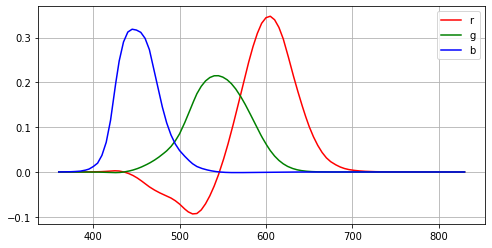

In [233]:
#
# Plot original rgb primary experiment
#
def _():
    lam = xyz_kernel_resampled[:, 0]
    r, g, b = CIE_XYZ_to_RGB @ xyz_kernel_resampled[:, 1:].T
    
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.grid()
    ax.plot(lam, r, label='r', color='r')
    ax.plot(lam, g, label='g', color='g')
    ax.plot(lam, b, label='b', color='b')
    ax.legend()
    
_()